In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
home_path = r'C:\Users\joche\FIM Kernkompetenzzentrum\Paper Agent-based Modeling - Dokumente\General\01 Data\load_profiles'
# get relevant file paths
bl_path = [i.path for i in os.scandir(home_path) if 'qh_residential_loads' in i.name][0]
ev_path = [i.path for i in os.scandir(home_path) if 'qh_residential_ev_loads_kWh' in i.name][0]
cc_path = r'C:\Users\joche\FIM Kernkompetenzzentrum\Paper Agent-based Modeling - Dokumente\General\04 ABM\03_data\custom_communities\2022 11 09 10h46m56s\filtered_buildings_incl_roofs.xlsx'

#### Read in existing data: Custom community, baseload and ev profile

In [3]:
# read in custom community folder "2022 11 09 10h46m56s"
cc = pd.read_excel(cc_path, index_col=0)
cc.reset_index(inplace=True)
cc.head(3)

index    HID  AREA_ROOF_sqm  ANNUAL_RADIATION_sqm  ANNUAL_RADIATION_kWh  \
0      0  12588     124.239014           1960.442017         243563.382503   
1      1  12593      59.689657           1911.446594         114093.591988   
2      2  12611      53.007076           1241.529541          65809.851064   

         STREET  NUMBER  ADDITION  ZIPCODE        CITY  AREA_BUILDING_sqm  \
0      Erlenweg       3       NaN    85049  Ingolstadt          119.87465   
1      Erlenweg       1       NaN    85049  Ingolstadt          102.85365   
2  Altenhofstr.      45       NaN    85049  Ingolstadt          102.20035   

   MEMBER_TYPE                                   RESIDENTIAL_TYPE  \
0  residential        Two_full-time_working_persons,_two_children   
1  residential        Two_full-time_working_persons,_two_children   
2  residential  One_full-time_and_one_part-time_working_person...   

  CONSUMER_TYPE  ROOF_PV_PERCENTAGE  HOME_BATTERY_CAPACITY_kW  NUMBER_EVS  \
0      consumer                 NaN                       NaN         1.0   
1      prosumer               100.0                      15.0         1.0   
2      prosumer                50.0                      15.0         NaN   

   EV_BATTERY_CAPACITY_kW  LOAD_FLEXIBILITY  
0                    50.0               0.1  
1                    50.0               0.1  
2                     NaN               0.1

In [4]:
# read in baseload and ev profiles for custom timeperiod
# winter: 01-15 until 01-22, summer: 06-15 until 06-22
df_bl = pd.read_excel(bl_path, index_col=0)
df_ev = pd.read_excel(ev_path, index_col=0)
df_bl.index = df_ev.index
df_bl.head(4)

One_full-time_and_one_part-time_working_person  \
2019-01-01 00:00:00                                        0.037117   
2019-01-01 00:15:00                                        0.036032   
2019-01-01 00:30:00                                        0.024566   
2019-01-01 00:45:00                                        0.024321   

                     One_full-time_and_one_part-time_working_person,_one_child  \
2019-01-01 00:00:00                                           0.037015           
2019-01-01 00:15:00                                           0.035174           
2019-01-01 00:30:00                                           0.024157           
2019-01-01 00:45:00                                           0.024412           

                     One_full-time_and_one_part-time_working_person,_three_children  \
2019-01-01 00:00:00                                           0.031027                
2019-01-01 00:15:00                                           0.031692                
2019-01-01 00:30:00                                           0.050259                
2019-01-01 00:45:00                                           0.038143                

                     One_full-time_and_one_part-time_working_person,_two_children  \
2019-01-01 00:00:00                                           0.026565              
2019-01-01 00:15:00                                           0.014833              
2019-01-01 00:30:00                                           0.028941              
2019-01-01 00:45:00                                           0.035957              

                     One_full-time_working_person  One_pensioneer  \
2019-01-01 00:00:00                      0.045490        0.011130   
2019-01-01 00:15:00                      0.043854        0.011199   
2019-01-01 00:30:00                      0.043161        0.025647   
2019-01-01 00:45:00                      0.025032        0.014659   

                     Two_full-time_working_persons  \
2019-01-01 00:00:00                       0.025384   
2019-01-01 00:15:00                       0.025051   
2019-01-01 00:30:00                       0.031577   
2019-01-01 00:45:00                       0.040364   

                     Two_full-time_working_persons,_one_child  \
2019-01-01 00:00:00                                  0.037916   
2019-01-01 00:15:00                                  0.028570   
2019-01-01 00:30:00                                  0.023894   
2019-01-01 00:45:00                                  0.034859   

                     Two_full-time_working_persons,_three_children  \
2019-01-01 00:00:00                                       0.038632   
2019-01-01 00:15:00                                       0.044234   
2019-01-01 00:30:00                                       0.054716   
2019-01-01 00:45:00                                       0.048315   

                     Two_full-time_working_persons,_two_children  \
2019-01-01 00:00:00                                     0.013793   
2019-01-01 00:15:00                                     0.024146   
2019-01-01 00:30:00                                     0.027266   
2019-01-01 00:45:00                                     0.013588   

                     Two_pensioneers  
2019-01-01 00:00:00         0.024360  
2019-01-01 00:15:00         0.036073  
2019-01-01 00:30:00         0.035609  
2019-01-01 00:45:00         0.024332

#### Assign baseload and ev profile to each community member

In [5]:
def get_bl_cc(start, end):
    df_bl_cc = pd.DataFrame(index = pd.date_range(start, end, freq='15min'))[:-1]
    for idx, row in cc.iterrows():
        ind = row['index']
        df_bl_cc[f'ID_{ind}'] = df_bl.loc[(df_bl.index >= start) & (df_bl.index < end), row['RESIDENTIAL_TYPE']]
    return df_bl_cc

def get_ev_cc(start, end):
    df_ev_cc = pd.DataFrame(index = pd.date_range(start, end, freq='15min'))[:-1]
    for idx, row in cc.iterrows():
        ind = row['index']
        df_ev_cc[f'ID_{ind}'] = df_ev.loc[(df_ev.index >= start) & (df_ev.index < end), row['RESIDENTIAL_TYPE']]
    return df_ev_cc

In [6]:
plt.rcParams.update({'font.size': 15})

In [97]:
import seaborn as sns
sns.set_style('white')

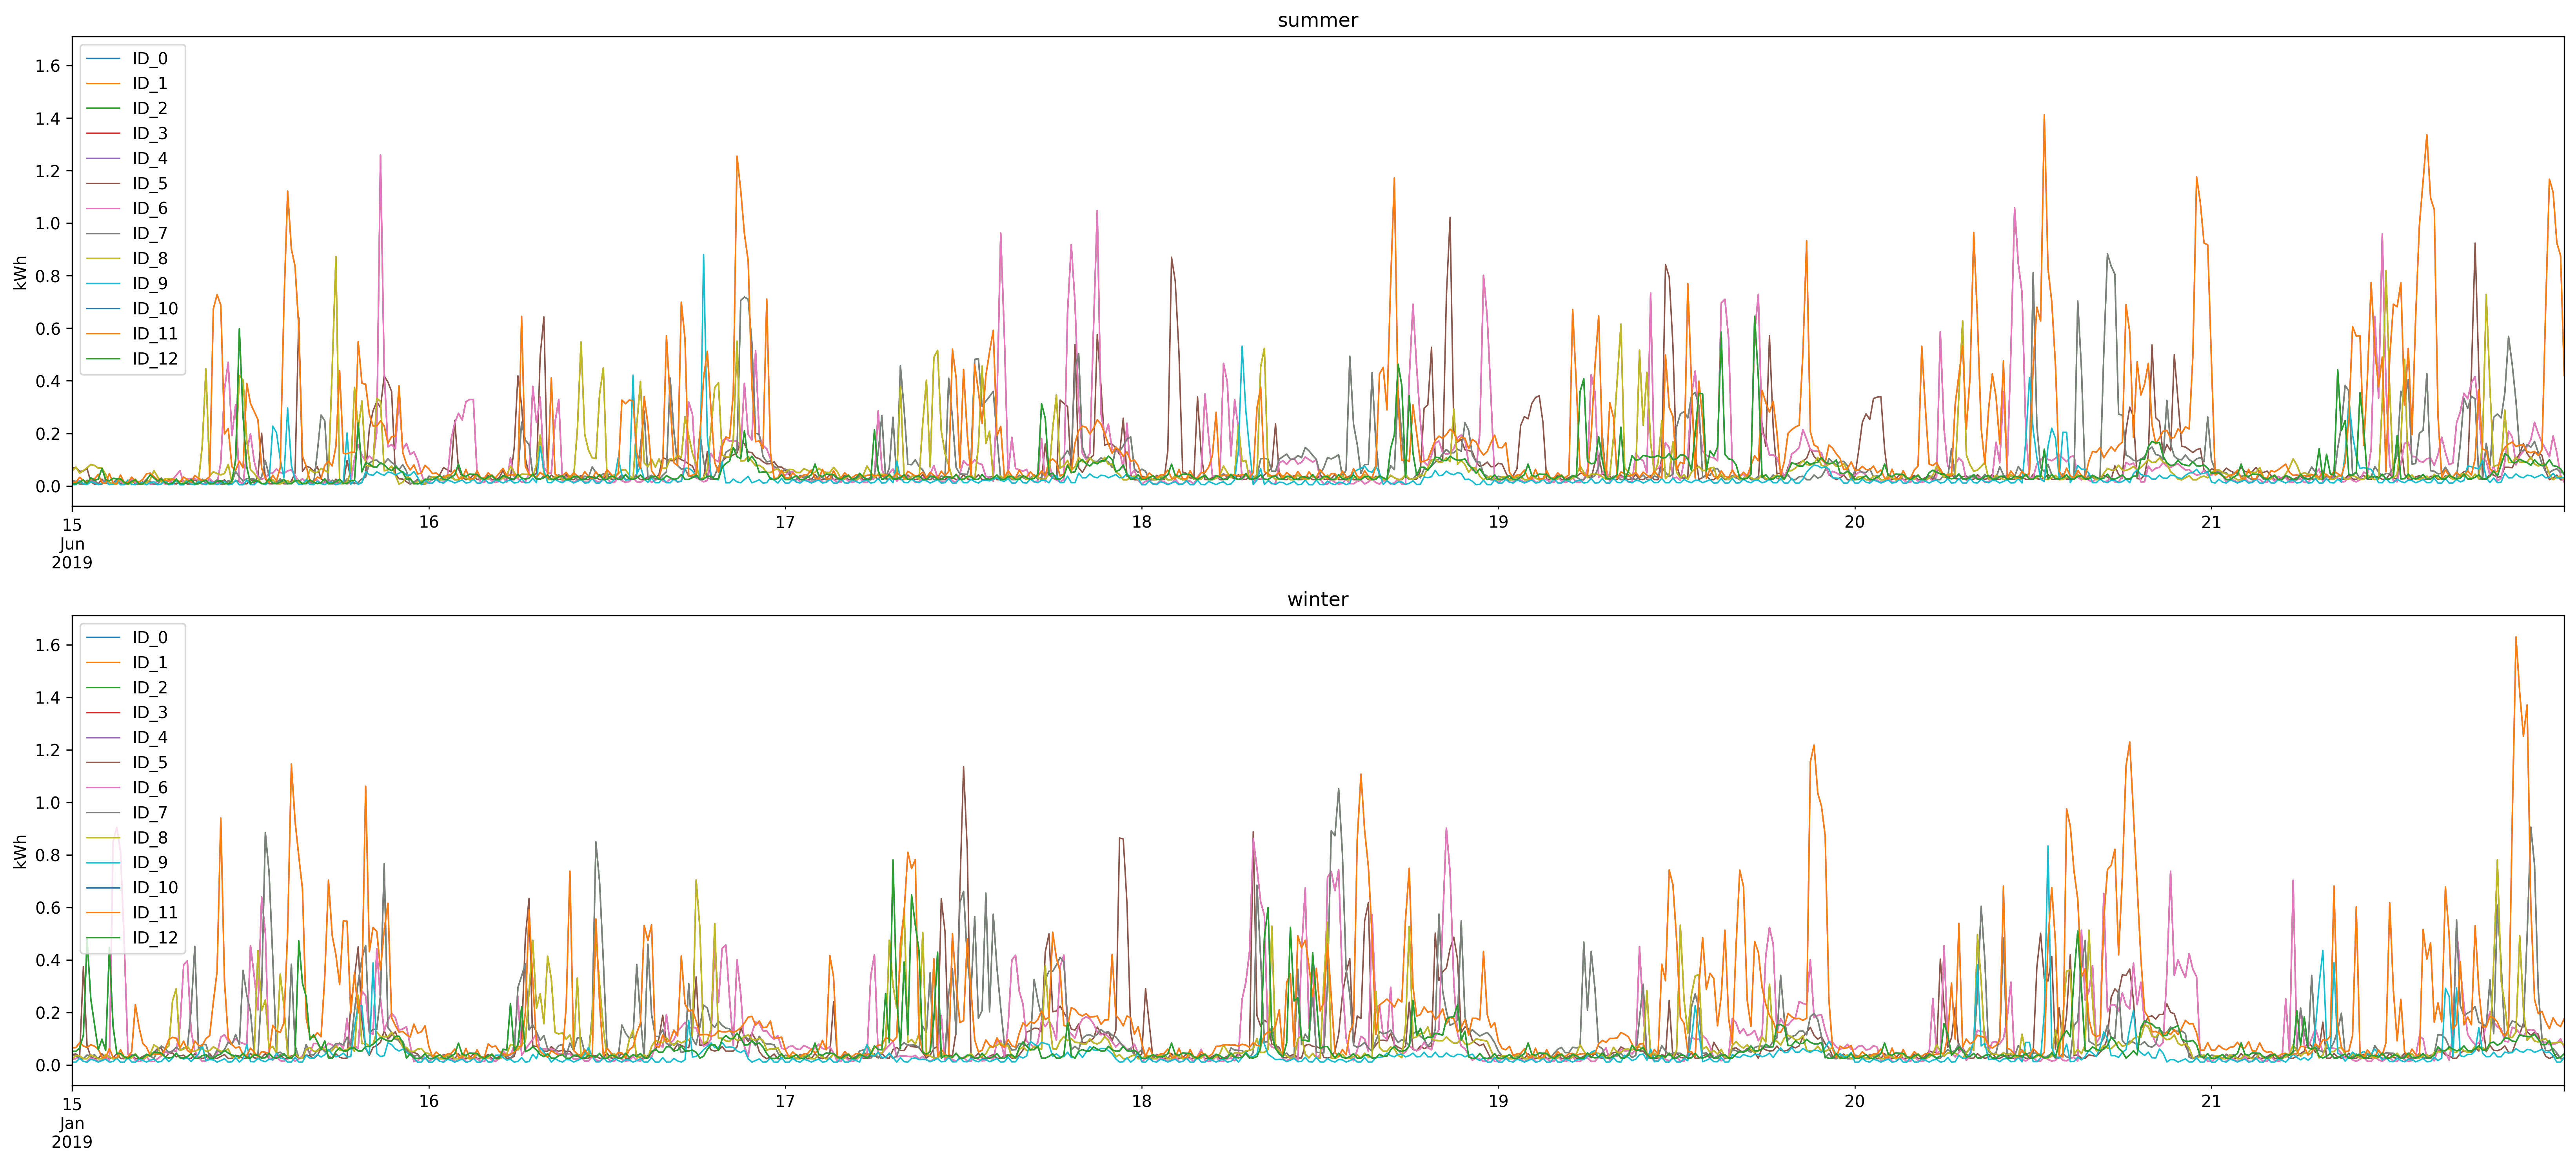

In [7]:
s19_start, s19_end, w19_start, w19_end = '2019-06-15', '2019-06-22', '2019-01-15', '2019-01-22'
#s22_start, s22_end, w22_start, w22_end = '2022-06-15', '2022-06-22', '2022-01-15', '2022-01-22'

fig, ax = plt.subplots(figsize = (22,10), nrows=2, sharey=True)
l1 = get_bl_cc(s19_start, s19_end).plot(ax=ax[0], xlabel='', ylabel='kWh', linewidth = .9, title='summer')
l2 = get_bl_cc(w19_start, w19_end).plot(ax=ax[1], xlabel='', ylabel='kWh', linewidth = .9, title='winter')
plt.tight_layout()
plt.gcf().set_dpi(300)

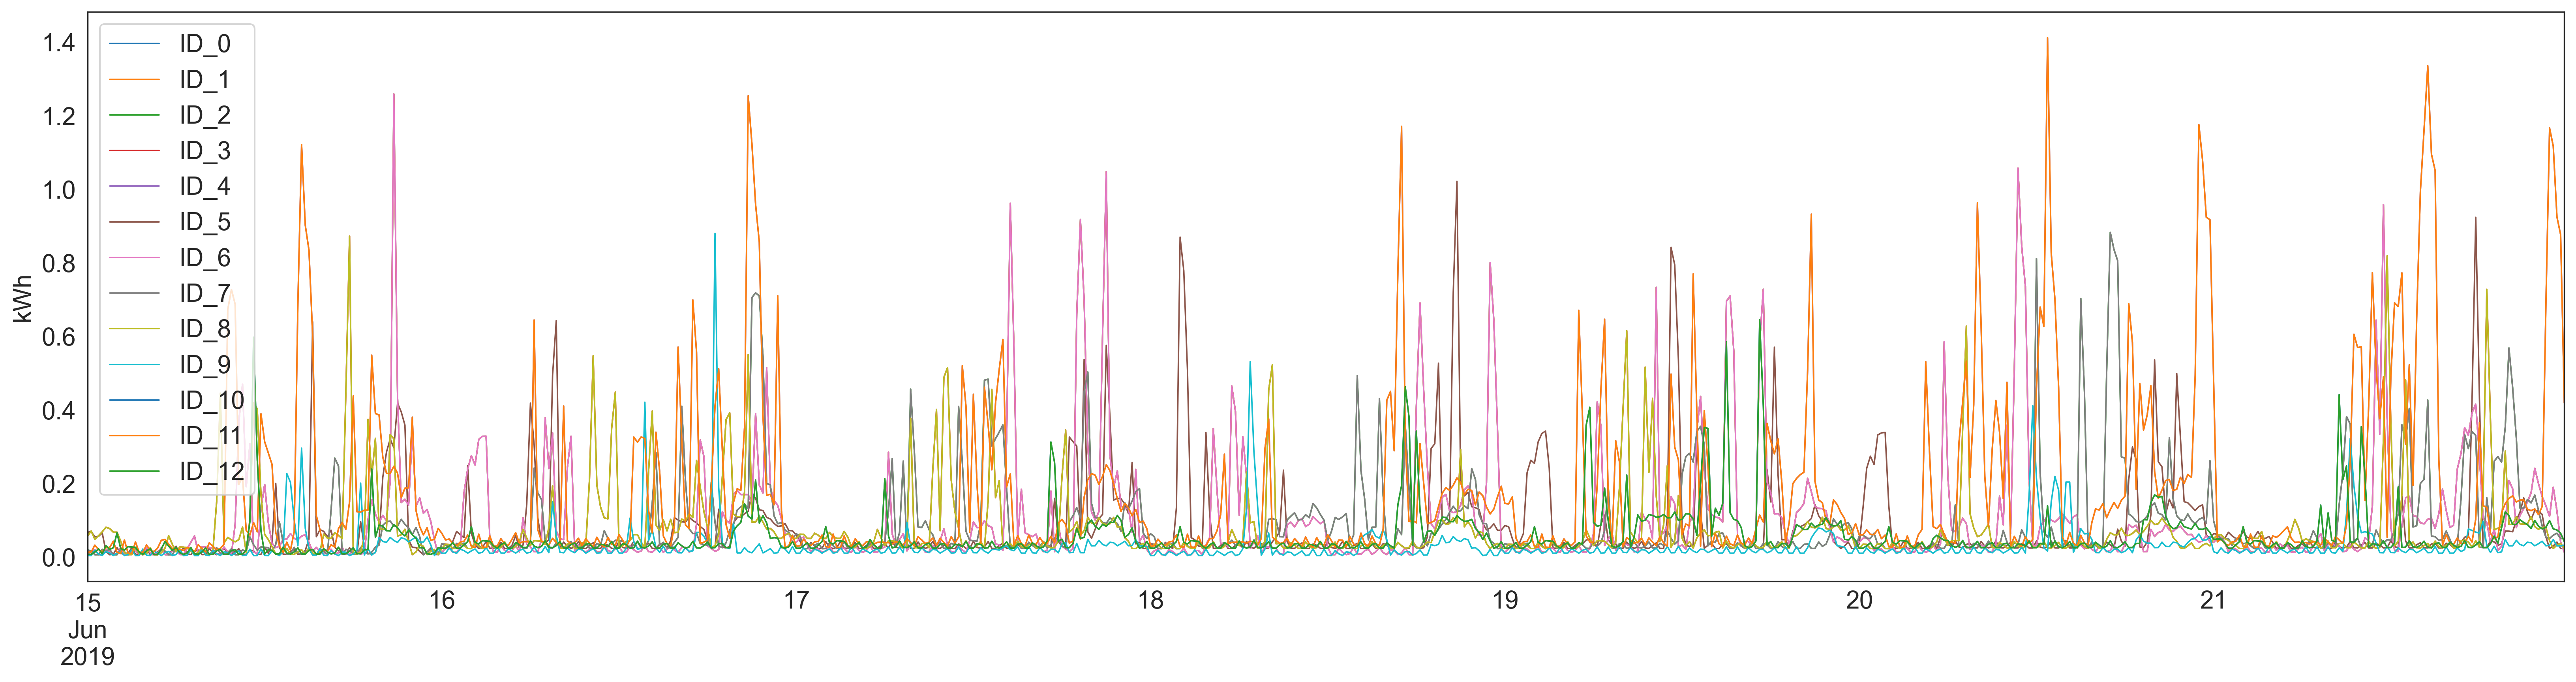

In [121]:
l1 = get_bl_cc(s19_start, s19_end).plot(xlabel='', ylabel='kWh', linewidth = .9, figsize=(22,6))
plt.tight_layout()
plt.gcf().set_dpi(300)

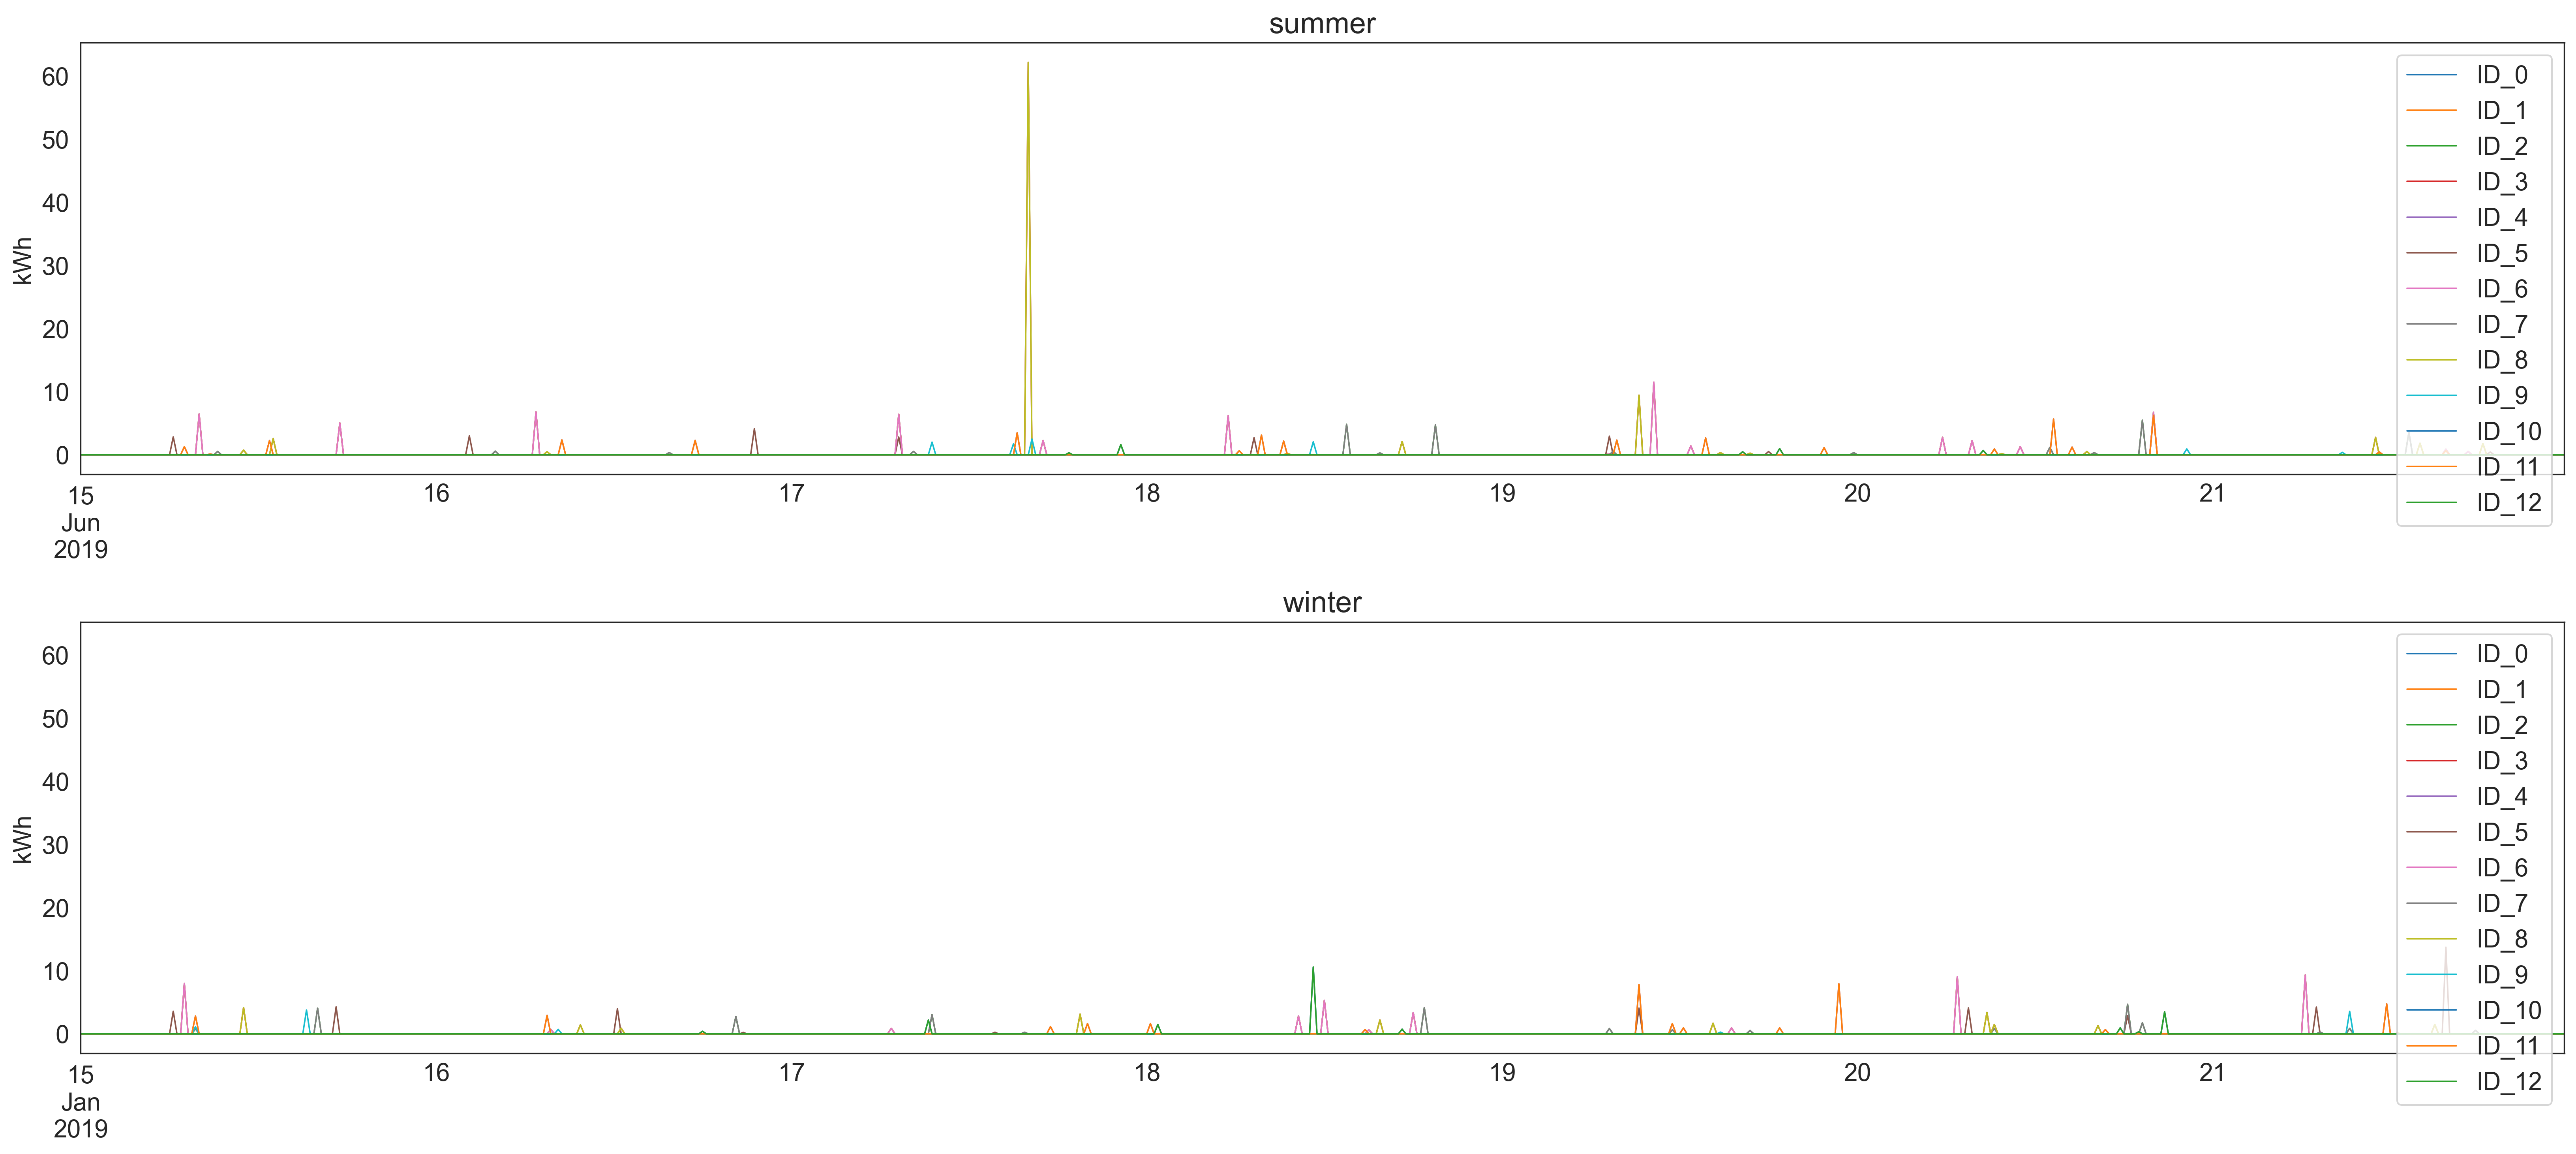

In [112]:
s19_start, s19_end, w19_start, w19_end = '2019-06-15', '2019-06-22', '2019-01-15', '2019-01-22'
#s22_start, s22_end, w22_start, w22_end = '2022-06-15', '2022-06-22', '2022-01-15', '2022-01-22'

fig, ax = plt.subplots(figsize = (22,10), nrows=2, sharey=True)
l1 = get_ev_cc(s19_start, s19_end).plot(ax=ax[0], xlabel='', ylabel='kWh', linewidth = .9, title='summer')
#l2 = get_ev_cc(w19_start, w19_end).plot(ax=ax[1], xlabel='', ylabel='kWh', linewidth = .9, title='winter')
plt.tight_layout()
plt.gcf().set_dpi(300)

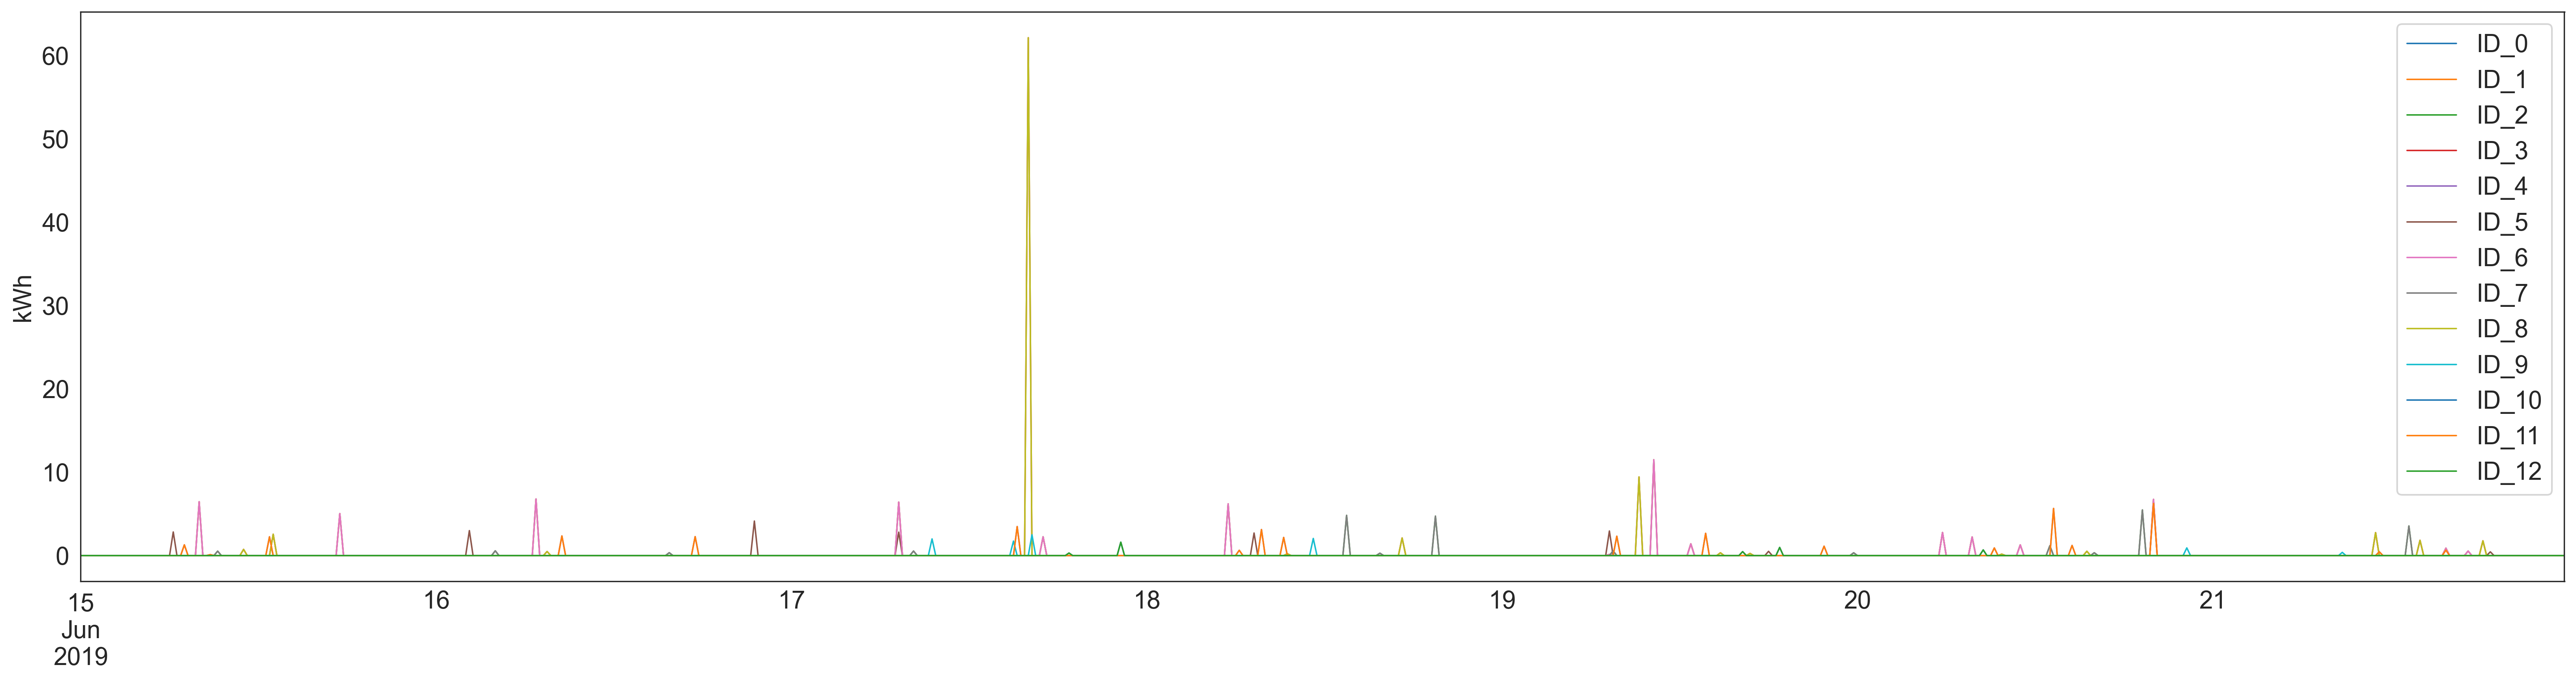

In [122]:
l1 = get_ev_cc(s19_start, s19_end).plot(xlabel='', ylabel='kWh', linewidth = .9, figsize=(22,6))
plt.tight_layout()
plt.gcf().set_dpi(300)